Mounted at /content/drive


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Epoch 1/10, Loss: 0.8621008491010185, Accuracy: 0.7751479289940828
Epoch 2/10, Loss: 0.6644770207878912, Accuracy: 0.8279942868802285
Epoch 3/10, Loss: 0.6377460785822779, Accuracy: 0.8279942868802285
Epoch 4/10, Loss: 0.6194822440656247, Accuracy: 0.8279942868802285
Epoch 5/10, Loss: 0.6004311347148827, Accuracy: 0.8279942868802285
Epoch 6/10, Loss: 0.5914828758340932, Accuracy: 0.8279942868802285
Epoch 7/10, Loss: 0.5807825648110878, Accuracy: 0.8279942868802285
Epoch 8/10, Loss: 0.5785458248091143, Accuracy: 0.8279942868802285
Epoch 9/10, Loss: 0.567657225401006, Accuracy: 0.8279942868802285
Epoch 10/10, Loss: 0.5624719541964543, Accuracy: 0.8279942868802285
Confusion Matrix:
[[   0    0  191]
 [   0    0  211]
 [   0    0 1699]]

Classification Report:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       191
     neutral       0.00      0.00      0.00       211
    positive       0.81      1.00      0.89      1699

    accuracy   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


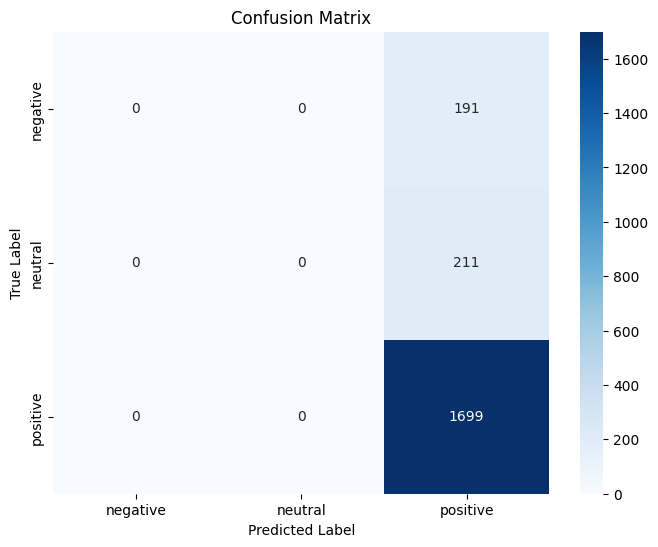

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from gensim.models import KeyedVectors
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

drive.mount('/content/drive')

# Load dataset
data_path = '/content/drive/My Drive/experiment/trip-advisor.csv'
data = pd.read_csv(data_path)

# Preprocessing: Text Cleaning, Tokenization, and Normalization
nltk.download('punkt')

def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I | re.A)
    text = re.sub(r'\s+', ' ', text).strip()
    return text.lower()

data['Cleaned_Review'] = data['Review'].apply(clean_text)

# Adjust labels for sentiment analysis
data['Sentiment'] = pd.cut(data['Rating'], bins=[-np.inf, 2, 3, np.inf], labels=['negative', 'neutral', 'positive'], right=False)

# Split data into train and test sets (70% train, 30% test)
train_texts, test_texts, train_labels, test_labels = train_test_split(
    data['Cleaned_Review'], data['Sentiment'], test_size=0.3, random_state=42)

# Load FastText model
fasttext_model_path = '/content/drive/My Drive/experiment/wiki-news-300d-1M.vec'
fasttext_vectors = KeyedVectors.load_word2vec_format(fasttext_model_path, binary=False)

# Convert text data to FastText vectors (average of word vectors)
def text_to_vector(text):
    tokens = nltk.word_tokenize(text.lower())
    vectors = [fasttext_vectors[word] for word in tokens if word in fasttext_vectors]
    return np.mean(vectors, axis=0) if vectors else np.zeros(300)

train_vectors = np.array([text_to_vector(text) for text in train_texts])
test_vectors = np.array([text_to_vector(text) for text in test_texts])

# LSTM Model
class SentimentLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SentimentLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :] if len(lstm_out.shape) > 2 else lstm_out
        output = self.fc(lstm_out)
        return output

# Define parameters
input_size = 300  # Size of FastText word vectors
hidden_size = 128
output_size = len(data['Sentiment'].unique())

# Create LSTM model instance
lstm_model = SentimentLSTM(input_size, hidden_size, output_size)

# Define optimizer and loss function
optimizer = optim.Adam(lstm_model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()

# Convert data to tensors
train_vectors_tensor = torch.tensor(train_vectors, dtype=torch.float32)
test_vectors_tensor = torch.tensor(test_vectors, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels.cat.codes.values, dtype=torch.long)
test_labels_tensor = torch.tensor(test_labels.cat.codes.values, dtype=torch.long)

# Define DataLoader
train_dataset = torch.utils.data.TensorDataset(train_vectors_tensor, train_labels_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)

# Training loop
def train_model(model, train_loader, optimizer, loss_fn, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_predictions = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct_predictions / len(train_loader.dataset)

        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss}, Accuracy: {epoch_acc}')

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lstm_model = lstm_model.to(device)

# Train the LSTM model
train_model(lstm_model, train_loader, optimizer, loss_fn, num_epochs=10)

# Evaluate the model
def evaluate_model(model, test_vectors_tensor, test_labels_tensor):
    model.eval()
    with torch.no_grad():
        outputs = model(test_vectors_tensor)
        _, predicted = torch.max(outputs, 1)
        cm = confusion_matrix(test_labels_tensor.cpu(), predicted.cpu())
        cr = classification_report(test_labels_tensor.cpu(), predicted.cpu(), target_names=['negative', 'neutral', 'positive'])
    return cm, cr

# Convert test data to tensor
test_vectors_tensor = test_vectors_tensor.to(device)
test_labels_tensor = test_labels_tensor.to(device)

# Evaluate the LSTM model
conf_matrix, class_report = evaluate_model(lstm_model, test_vectors_tensor, test_labels_tensor)
print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

# Confusion Matrix Visualization
def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(conf_matrix, ['negative', 'neutral', 'positive'])
